In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import warnings

# Filter out the specific warning message
warnings.filterwarnings("ignore", message="Intel MKL WARNING")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
class_names = Base.classes.keys()
class_names

['station', 'measurement']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23',)

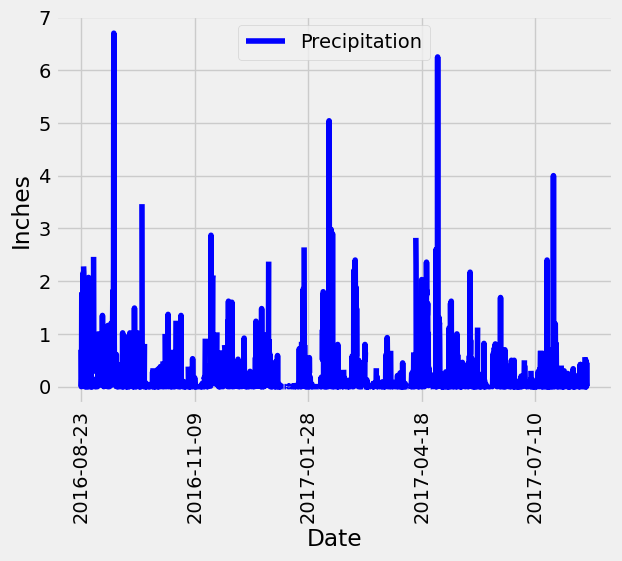

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date=session.query(measurement.date).order_by(measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
most_recent_date = pd.to_datetime(recent_date[0])
query_date = most_recent_date - dt.timedelta(days=365)

# Convert query_date to a regular datetime object
query_date = query_date.date()

# Convert recent_date to a regular datetime object
recent_date = recent_date[0]

# Perform a query to retrieve the data and precipitation scores
retrieve_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= query_date).\
    order_by(measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df_unsort = pd.DataFrame(retrieve_data, columns=["Date", "Precipitation"])

# Sort the DataFrame by date in descending order
prcp_df = prcp_df_unsort.sort_values(by="Date")

# Create a line plot using the index as the x-axis 
prcp_df.plot(x='Date', y='Precipitation', kind='line', color='blue',rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.grid(True)


plt.legend(loc='upper center')
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary= pd.DataFrame(prcp_df['Precipitation'].describe())
summary

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.id)).all()
total_stations

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(station.station, func.count(measurement.station).label('count')) \
    .join(measurement, station.station == measurement.station) \
    .group_by(station.station) \
    .order_by(func.count(measurement.station).desc()) \
    .all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Define the most active station ID
most_active_station_id = active_stations[0][0]

# Calculate the minimum, maximum, and average temperature in one query
statistics_temp = session.query(func.min(measurement.tobs), 
                       func.max(measurement.tobs), 
                       func.avg(measurement.tobs)).\
                       filter(measurement.station == most_active_station_id).all()
statistics_temp

[(54.0, 85.0, 71.66378066378067)]

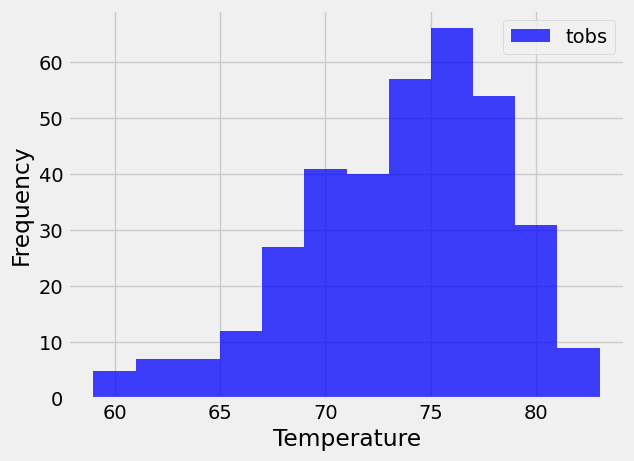

In [15]:
# Query the last 12 months of temperature observation data for the most active station
from datetime import datetime, timedelta
from sqlalchemy import and_

# Calculate the date one year ago from the last date in the dataset
last_date = session.query(func.max(measurement.date)).\
    filter(measurement.station == most_active_station_id).scalar()
last_date = datetime.strptime(last_date, '%Y-%m-%d')
one_year_ago = last_date - timedelta(days=365)

# Query temperature data for the last 12 months
temperature_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station_id).\
    filter(measurement.date >= one_year_ago).all()
               

# Convert the query results to a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Tobs'])

# Plot a histogram of the temperature data
plt.hist(temperature_df['Tobs'], bins=12, label='tobs', alpha=0.75, color='blue')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()